In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import time

In [2]:
def I_gap(i, big_V, big_G_gap):
    sum = 0
    for j in range(len(big_V)):
        sum += big_G_gap[i, j] * (big_V[i] - big_V[j])

    return sum

def I_syn(i, big_V, big_E, big_s, big_G_syn):
    sum = 0
    for j in range(len(big_V)):
        sum += big_G_syn[i, j] * big_s[j] * (big_V[i] - big_E[j])
    return sum

In [3]:
def delta_s(V_m, s_i):
    a_r = 1
    a_d = 5
    beta = 0.125
    V_th = -15 #??

    sig = 1 / (1 + np.exp(-beta * (V_m - V_th)))

    return a_r * sig * (1 - s_i) - a_d * s_i

# Simple version
def new_s(V_m):
    a_r = 1
    a_d = 5
    beta = 0.125
    V_th = -20 #??
    sig = 1 / (1 + np.exp(-beta * (V_m - V_th)))

    return (a_r * sig) / (a_r * sig + a_d)

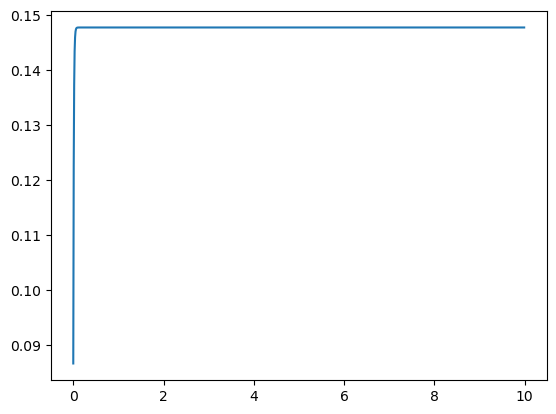

In [4]:
s = 0
s_array = []
t_array = []
for i in range(100 * 10):

    d_s = delta_s(0, s)
    s += d_s * 0.1
    t_array.append(i * 0.01)
    s_array.append(s)

plt.plot(t_array, s_array)

In [5]:
def I_leak(V_m):
    E_leak = -35 #mV
    G_leak = 10 #pS I think

    return G_leak * (V_m - E_leak)

In [6]:
def delta_V_m(V_m, I_leak, I_gap, I_syn, I_in):
    C_m = 1 #pF

    current_sum = -I_leak - I_gap - I_syn + I_in
    return current_sum / C_m

In [7]:
def basic_sim(time_step, run_time, input_amount=50, in_start=0.4, in_end=0.6, simplified=False):
    input_current = np.array([0])
    
    # Set inital values
    big_V = np.array([-40.0])
    big_G_gap = np.array([[0.0]])
    big_G_syn = np.array([[0.0]])
    big_E = np.array([0.0])
    big_s = np.array([0.5])
    indices = np.array([0])
    
    t = 0

    # Storage
    big_V_array = []
    
    I_leak_array = []
    I_in_array = []
    I_syn_array = []
    big_s_array = []
    time = []

    # In seconds (?)
    time_range = int(run_time / time_step)
    start_index = int(time_range * in_start)
    end_index = int(time_range * in_end)

    for i in range(time_range):
        if i == time_range // 4:
            print("25%")
        if i == time_range // 2:
            print("50%")
        if i == (time_range // 4) * 3:
            print("75%")

        if i == start_index:
            input_current[0] = input_amount
        
        if i == end_index:
            input_current[0] = 0

        # Time stuff
        time.append(t)
        t += time_step

        # Calculate
        leak_current = I_leak(big_V)
        
        gap_current = I_gap(indices, big_V, big_G_gap)
        syn_current = I_syn(indices, big_V, big_E, big_s, big_G_syn)
        
        d_V_m = delta_V_m(big_V, leak_current, gap_current, syn_current, input_current)
        d_s = delta_s(big_V, big_s)
        
        #Update
        if simplified:
            big_s = new_s(big_V)
        else:
            big_s += d_s * time_step
        
        big_V += d_V_m * time_step
        
        
        #Store
        big_V_array.append(big_V.copy())
        big_s_array.append(big_s.copy())
        I_leak_array.append(leak_current.copy())
        I_in_array.append(input_current.copy())
        I_syn_array.append(syn_current.copy())

    return [time, np.array(big_V_array) ,np.array(I_leak_array), np.array(I_in_array), np.array(I_syn_array), big_s_array]

25%
50%
75%


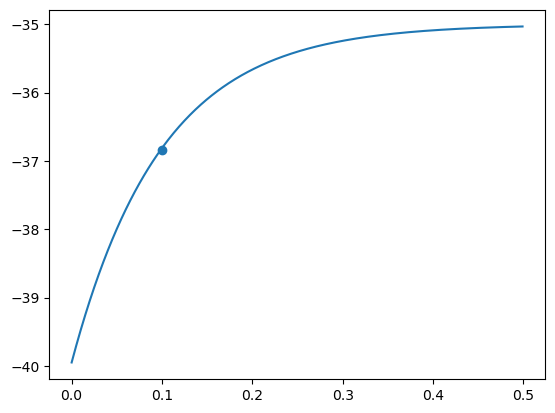

In [8]:
results = basic_sim(0.001, 0.5, in_start=1.2, in_end=1.2)
plt.plot(results[0], results[1])
plt.scatter(0.1, -36.839)

In [9]:
def start_sim(time_step, run_time, input_amount=50, in_start=0.4, in_end=0.6, volts=-40.0, syn_amt=1, simplified=False):
    input_current = np.array([0, 0])
    
    # Set inital values
    big_V = np.array([volts, -40.0])
    big_G_gap = np.array([[0.0, 0.0],[0.0,0.0]])
    big_G_syn = np.array([[0.0, syn_amt * 100.0], [100.0, 0.0]])
    big_E = np.array([0.0, 0.0])
    big_s = np.array([0.5, 0.5])
    indices = np.array([0, 1])
    
    t = 0

    # Storage
    big_V_array = []
    
    I_leak_array = []
    I_in_array = []
    I_syn_array = []
    big_s_array = []
    time = []

    # In seconds (?)
    time_range = int(run_time / time_step)
    start_index = int(time_range * in_start)
    end_index = int(time_range * in_end)

    for i in range(time_range):
        if i == time_range // 4:
            print("25%")
        if i == time_range // 2:
            print("50%")
        if i == (time_range // 4) * 3:
            print("75%")

        if i == start_index:
            input_current[0] = input_amount
        
        if i == end_index:
            input_current[0] = 0

        # Time stuff
        time.append(t)
        t += time_step

        # Calculate
        leak_current = I_leak(big_V)
        
        gap_current = I_gap(indices, big_V, big_G_gap)
        syn_current = I_syn(indices, big_V, big_E, big_s, big_G_syn)
        
        d_V_m = delta_V_m(big_V, leak_current, gap_current, syn_current, input_current)
        d_s = delta_s(big_V, big_s)

        # Voltage clamp
        d_V_m[0] = 0
        
        #Update
        if simplified:
            big_s = new_s(big_V)
        else:
            big_s += d_s * time_step
        
        big_V += d_V_m * time_step
        
        
        #Store
        big_V_array.append(big_V.copy())
        big_s_array.append(big_s.copy())
        I_leak_array.append(leak_current.copy())
        I_in_array.append(input_current.copy())
        I_syn_array.append(syn_current.copy())

    return [time, np.array(big_V_array) ,np.array(I_leak_array), np.array(I_in_array), np.array(I_syn_array), big_s_array]

In [10]:
def show_data(res, start=0, end=-1):
    plt.plot(res[0][start:end], res[1][start:end, 0], label='V_m_0')
    plt.plot(res[0][start:end], res[1][start:end, 1], label='V_m_1')
    plt.legend(loc='best')
    plt.show()
    print("For 1:")
    plt.plot(res[0][start:end],res[2][start:end, 1], label='I_leak')
    plt.plot(res[0][start:end],res[3][start:end, 1], label='I_in')
    plt.plot(res[0][start:end],res[4][start:end, 1], label='I_syn')
    plt.legend(loc='best')
    plt.show()
    print("For 0:")
    plt.plot(res[0][start:end],res[2][start:end, 0], label='I_leak')
    plt.plot(res[0][start:end],res[3][start:end, 0], label='I_in')
    plt.plot(res[0][start:end],res[4][start:end, 0], label='I_syn')
    plt.legend(loc='best')
    plt.show()
    # Current by voltage
    plt.scatter(res[1][start:end:300],res[2][start:end:300], label='I_leak')
    plt.legend(loc='best')
    plt.show()

25%
50%
75%


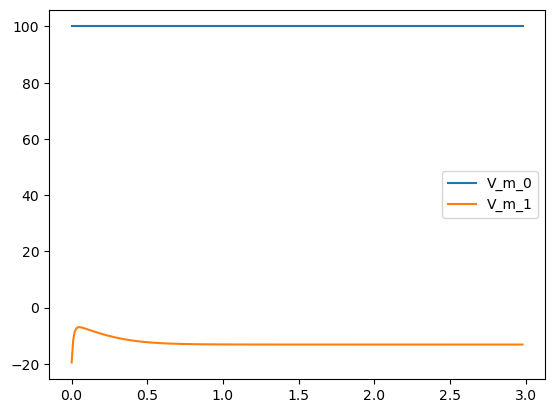

For 1:


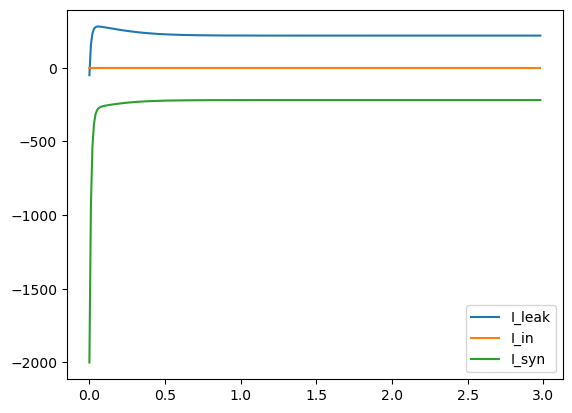

For 0:


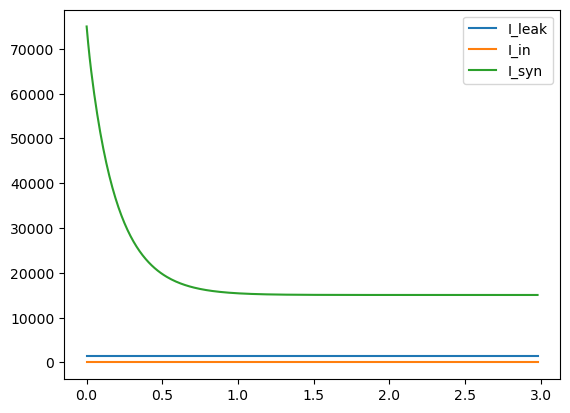

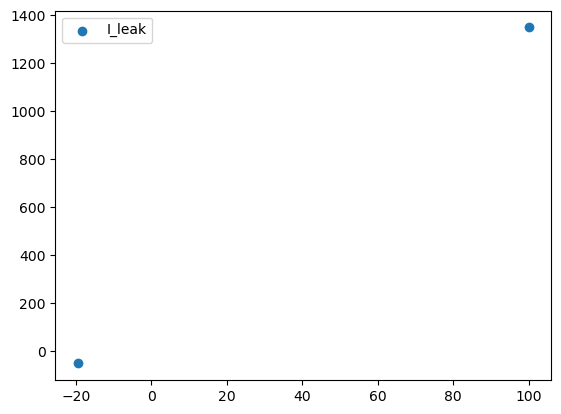

25%
50%
75%


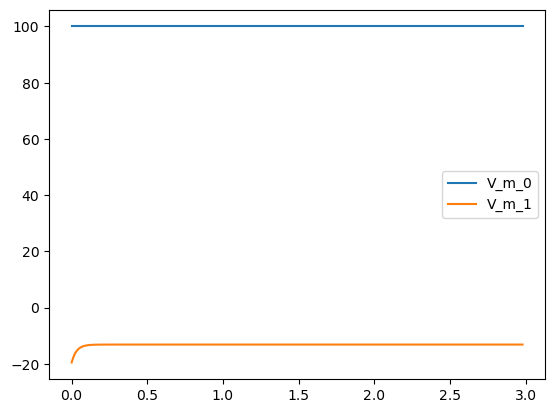

For 1:


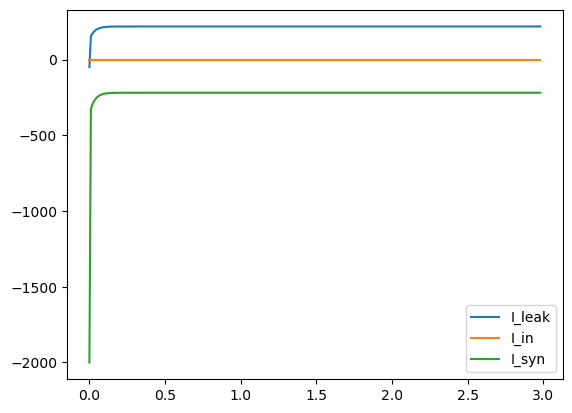

For 0:


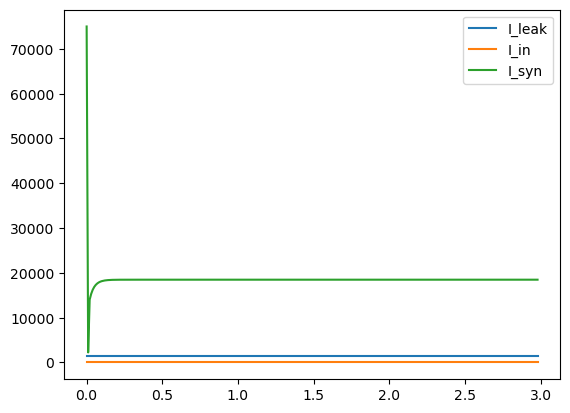

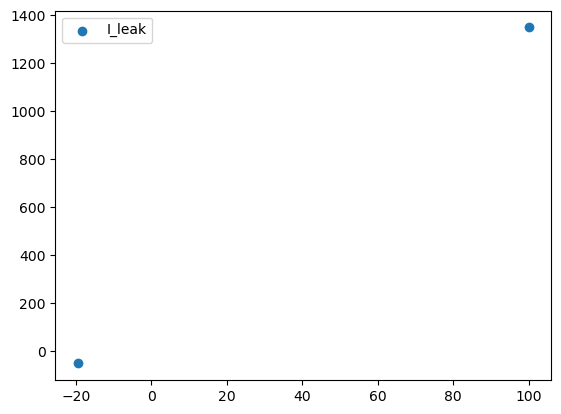

In [11]:
results = start_sim(0.01, 3.0, in_start=1.2, in_end=1.2, volts=100, syn_amt=15)
show_data(results)
results = start_sim(0.01, 3.0, in_start=1.2, in_end=1.2, volts=100, syn_amt=15, simplified=True)
show_data(results)

In [13]:
syn_results = []
simp_results = []
cls_results = []

for j in range(1, 20, 2):
    v_results = []
    s_results = []
    big_results = []
    
    for i in range(0, 300, 10):
        volts = -200.0 + i
        res = start_sim(0.001, 5.0, in_start=1.2, in_end=1.2, volts=volts, syn_amt=j)
        res_simple = start_sim(0.001, 5.0, in_start=1.2, in_end=1.2, volts=volts, syn_amt=j, simplified=True)
        v_results.append(res[4][-1])
        s_results.append(res_simple[4][-1])
        big_results.append(res[5][-1])

    syn_results.append(v_results)
    simp_results.append(s_results)
    cls_results.append(big_results)

25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%
50%
75%
25%


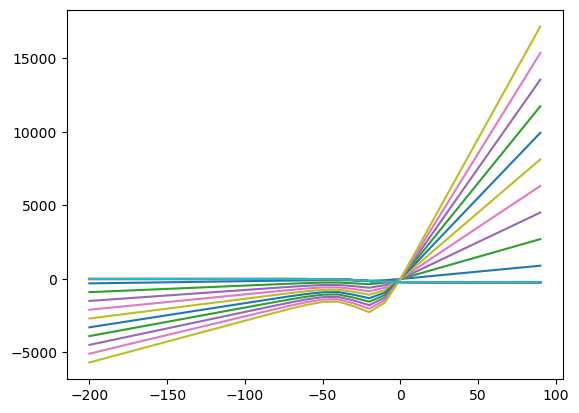

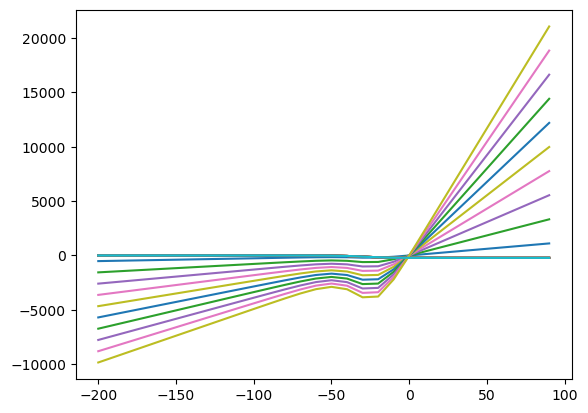

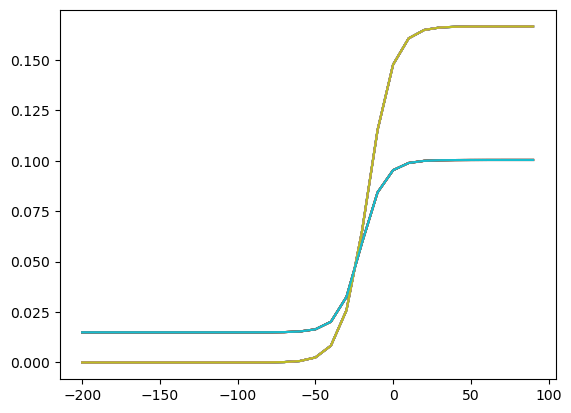

In [14]:
v_amounts = list(range(-200, 100, 10))

for i in range(10):
    plt.plot(v_amounts, syn_results[i])
plt.show()

for i in range(10):
    plt.plot(v_amounts, simp_results[i])
plt.show()

for i in range(10):
    plt.plot(v_amounts, cls_results[i])
plt.show()